![](https://i.ytimg.com/vi/dA_x2xHTYQE/maxresdefault.jpg)

<font size='5' color='blue' align = 'center'>Table of Contents</font> 
<font size='3' color='purple'>
1. [Introduction](#1)
1. [**Manual Search**](#2)
1. [**Grid Search**](#3)
1. [**Random Search**](#4)
1. [Automated Hyperparameter Tuning](#5)
    1. [Bayesian Optimization using **HyperOpt**](#51)
    1. [Genetic Algorithms using **TPOT**](#52)
    1. [Artificial Neural Networks (ANNs) Tuning](#53)
1. [**Optuna**](#6)    
1. [**Tune**](#7)    
1. [**Sherpa**](#8)    
1. [Conclusion](#9)  

# 1. Introduction <a id="1"></a> <br>

**Hyperparameter tuning** is choosing a set of optimal hyperparameters for a learning algorithm.

**What is a hyperparameter?

**A hyperparameter is a parameter whose value is set before the learning process begins.**

Some examples of hyperparameters include penalty in logistic regression and loss in stochastic gradient descent.

In sklearn, hyperparameters are passed in as arguments to the constructor of the model classes.

Hyper-parameters are parameters that are not directly learnt within estimators. In scikit-learn they are passed as arguments to the constructor of the estimator classes. Typical examples include C, kernel and gamma for Support Vector Classifier, alpha for Lasso, etc.

It is possible and recommended to search the hyper-parameter space for the best Cross-validation i.e evaluating estimator performance score.

Any parameter provided when constructing an estimator may be optimized in this manner. Specifically, to find the names and current values for all parameters for a given estimator, we can use the following method

estimator.get_params()

A search consists of:

* an estimator (regressor or classifier such as sklearn.svm.SVC());
* a parameter space;
* a method for searching or sampling candidates;
* a cross-validation scheme;
* a score function.

Some models allow for specialized, efficient parameter search strategies, outlined below.

Two generic approaches to sampling search candidates are provided in scikit-learn:
![](https://developer.qualcomm.com/sites/default/files/attachments/learning_resources_03-05.png)
**GridSearchCV** :For given values, GridSearchCV exhaustively considers all parameter combinations. The grid search provided by GridSearchCV exhaustively generates candidates from a grid of parameter values specified with the param_grid parameter.
For instance, the following param_grid specifies that it has one grid to be explored that is a linear kernel with alpha values in [0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0009], and 'max_iter' i.e maximum 10000 iterations.

param_grid = {'alpha':[0.01,0.001,0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0009],'max_iter':[10000]}

**RandomizedSearchCV**: It can sample a given number of candidates from a parameter space with a specified distribution.
After describing these tools we detail best practice applicable to both approaches.

Note that it is common that a small subset of those parameters can have a large impact on the predictive or computation performance of the model while others can be left to their default values. It is recommend to read the docstring of the estimator class to get a finer understanding of their expected behavior.

I think it is enough of the theory .Now lets jump into practice.

To perform Hyperparameters Optimization in Python, we will use Credit Card Fraud Detection Dataset. 

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
df = pd.read_csv(r'C:\Users\iyers\Classes\PluralSight\ML_Content\Optimization_in_ML\data\creditcard\creditcard.csv',na_values = '#NAME?')

In [3]:
X = df[['V17', 'V9', 'V6', 'V12']]
Y = df['Class']

In [4]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size = 0.30,random_state = 101)

# 2. Manual Search <a id="2"></a> <br>
We will use a Random Forest Classifier as our model to optimize.Random Forest models are formed by a large number of uncorrelated decision trees, which joint together constitute an ensemble. In Random Forest, each decision tree makes its own prediction and the overall model output is selected to be the prediction which appeared most frequently.

We can now start by calculating our base model accuracy.

In [5]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier(random_state= 101).fit(X_Train,Y_Train)
predictionforest = model.predict(X_Test)
print(confusion_matrix(Y_Test,predictionforest))
print(classification_report(Y_Test,predictionforest))
acc1 = accuracy_score(Y_Test,predictionforest)

[[85289    10]
 [   34   110]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85299
           1       0.92      0.76      0.83       144

    accuracy                           1.00     85443
   macro avg       0.96      0.88      0.92     85443
weighted avg       1.00      1.00      1.00     85443



When using Manual Search, we choose some model hyperparameters based on our judgment/experience. We then train the model, evaluate its accuracy and start the process again. This loop is repeated until a satisfactory accuracy is scored.

The main parameters used by a Random Forest Classifier are:

* criterion = the function used to evaluate the quality of a split.
* max_depth = maximum number of levels allowed in each tree.
* max_features = maximum number of features considered when splitting a node.
* min_samples_leaf = minimum number of samples which can be stored in a tree leaf.
* min_samples_split = minimum number of samples necessary in a node to cause node splitting.
* n_estimators = number of trees in the ensemble.

In [6]:
model = RandomForestClassifier(n_estimators=10, random_state= 101).fit(X_Train,Y_Train)
predictionforest = model.predict(X_Test)
print(confusion_matrix(Y_Test,predictionforest))
print(classification_report(Y_Test,predictionforest))
acc2 = accuracy_score(Y_Test,predictionforest)

[[85288    11]
 [   41   103]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85299
           1       0.90      0.72      0.80       144

    accuracy                           1.00     85443
   macro avg       0.95      0.86      0.90     85443
weighted avg       1.00      1.00      1.00     85443



# 3. Random Search <a id="3"></a> <br>

In Random Search, we create a grid of hyperparameters and train/test our model on just some random combination of these hyperparameters. In this example, I additionally decided to perform Cross-Validation on the training set.

When performing Machine Learning tasks, we generally divide our dataset in training and test sets. This is done so that to test our model after having trained it (in this way we can check it’s performances when working with unseen data). When using Cross-Validation, we divide our training set into N other partitions to make sure our model is not overfitting our data.

One of the most common used Cross-Validation methods is K-Fold Validation. In K-Fold, we divide our training set into N partitions and then iteratively train our model using N-1 partitions and test it with the left-over partition (at each iteration we change the left-over partition). Once having trained N times the model we then average the training results obtained in each iteration to obtain our overall training performance results.

Using Cross-Validation when implementing Hyperparameters optimization can be really important. In this way, we might avoid using some Hyperparameters which works really good on the training data but not so good with the test data.
We can now start implementing Random Search by first defying a grid of hyperparameters which will be randomly sampled when calling RandomizedSearchCV().

In [7]:
import numpy as np 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

random_search = {'criterion': ['entropy', 'gini'],
               'max_depth': [2],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [4, 6, 8],
               'min_samples_split': [5, 7,10],
               'n_estimators': [20]}

clf = RandomForestClassifier()
model = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 10, 
                               cv = 4, verbose= 1, random_state= 101, n_jobs = -1)
model.fit(X_Train,Y_Train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [2],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [4, 6, 8],
                                        'min_samples_split': [5, 7, 10],
                                        'n_estimators': [20]},
                   random_state=101, verbose=1)

Once trained our model, we can then visualize how changing some of its Hyperparameters can affect the overall model accuracy. In this case, I decided to observe how changing the number of estimators and the criterion can affect our Random Forest accuracy.

<AxesSubplot: xlabel='param_criterion', ylabel='param_n_estimators'>

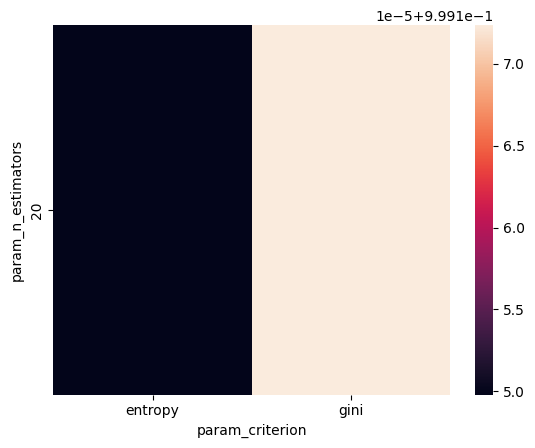

In [8]:
import seaborn as sns

table = pd.pivot_table(pd.DataFrame(model.cv_results_),
    values='mean_test_score', index='param_n_estimators', 
                       columns='param_criterion')
     
sns.heatmap(table)

We can now evaluate how our model performed using Random Search. In this case, using Random Search leads to a consistent increase in accuracy compared to our base model.

In [9]:
predictionforest = model.best_estimator_.predict(X_Test)
print(confusion_matrix(Y_Test,predictionforest))
print(classification_report(Y_Test,predictionforest))
acc3 = accuracy_score(Y_Test,predictionforest)

[[85280    19]
 [   45    99]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85299
           1       0.84      0.69      0.76       144

    accuracy                           1.00     85443
   macro avg       0.92      0.84      0.88     85443
weighted avg       1.00      1.00      1.00     85443



# 4. Grid Search <a id="4"></a> <br>
In Grid Search, we set up a grid of hyperparameters and train/test our model on each of the possible combinations.
In order to choose the parameters to use in Grid Search, we can now look at which parameters worked best with Random Search and form a grid based on them to see if we can find a better combination.

Grid Search can be implemented in Python using scikit-learn GridSearchCV() function.

In [10]:
from sklearn.model_selection import GridSearchCV

grid_search = {'criterion': ['entropy', 'gini'],
               'max_depth': [2],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [4, 6, 8],
               'min_samples_split': [5, 7,10],
               'n_estimators': [20]}

clf = RandomForestClassifier()
model = GridSearchCV(estimator = clf, param_grid = grid_search, 
                               cv = 4, verbose= 5, n_jobs = -1)
model.fit(X_Train,Y_Train)

predictionforest = model.best_estimator_.predict(X_Test)
print(confusion_matrix(Y_Test,predictionforest))
print(classification_report(Y_Test,predictionforest))
acc4 = accuracy_score(Y_Test,predictionforest)

Fitting 4 folds for each of 36 candidates, totalling 144 fits
[[85284    15]
 [   65    79]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85299
           1       0.84      0.55      0.66       144

    accuracy                           1.00     85443
   macro avg       0.92      0.77      0.83     85443
weighted avg       1.00      1.00      1.00     85443



Grid Search is slower compared to Random Search but it can be overall more effective because it can go through the whole search space. Instead, Random Search can be faster fast but might miss some important points in the search space.
# 5. Automated Hyperparameter Tuning <a id="5"></a> <br>

![](https://better.future-processing.com/directus/storage/uploads/2399317284eda5016daac68812d5d3c3.png)
As we have seen above tuning machine learning hyperparameters is indeed a tedious but crucial task, as the performance of an algorithm can be highly dependent on the choice of hyperparameters. Manual tuning takes time away from important steps of the machine learning pipeline like feature engineering and interpreting results. Grid and random search are hands-off, but require long run times because they waste time evaluating unpromising areas of the search space. Increasingly, hyperparameter tuning is done by automated methods that aim to find optimal hyperparameters in less time using an informed search with no manual effort necessary beyond the initial set-up.

When using Automated Hyperparameter Tuning, the model hyperparameters to use are identified using techniques such as: Bayesian Optimization, Gradient Descent and Evolutionary Algorithms.

## Bayesian Optimization using HyperOpt <a id="51"></a> <br>

![](https://i.imgur.com/BWbgCSx.jpg)
Bayesian optimization, a model-based method for finding the minimum of a function,while the final aim is to find the input value to a function which can give us the lowest possible output value has resulted in achieving better performance while requiring fewer iterations than random search.  Bayesian Optimization can, therefore, lead to better performance in the testing phase and reduced optimization time.

Bayesian Optimization can be performed in Python using the Hyperopt library.  

![](https://camo.githubusercontent.com/b92ead141ef3726da38eef053864aa1173012789/68747470733a2f2f692e706f7374696d672e63632f54506d66665772702f68797065726f70742d6e65772e706e67)

In Hyperopt, Bayesian Optimization can be implemented giving 3 three main parameters to the function fmin().

* **Objective Function** = defines the loss function to minimize.
* **Domain Space** = defines the range of input values to test (in Bayesian Optimization this space creates a probability distribution for each of the used Hyperparameters).
* **Optimization Algorithm** = defines the search algorithm to use to select the best input values to use in each new iteration.

Additionally, can also be defined in **fmin()** the maximum number of evaluations to perform.

Bayesian Optimization can reduce the number of search iterations by choosing the input values bearing in mind the past outcomes. In this way, we can concentrate our search from the beginning on values which are closer to our desired output.
We can now run our Bayesian Optimizer using the fmin() function. A Trials() object is first created to make possible to visualize later what was going on while the **fmin()** function was running (eg. how the loss function was changing and how to used Hyperparameters were changing).


Hyperopt is one of several automated hyperparameter tuning libraries using Bayesian optimization. These libraries differ in the algorithm used to both construct the surrogate (probability model) of the objective function and choose the next hyperparameters to evaluate in the objective function. Hyperopt uses the Tree Parzen Estimator (TPE). Other Python libraries include Spearmint, which uses a Gaussian process for the surrogate, and SMAC, which uses a random forest regression.

Hyperopt has a simple syntax for structuring an optimization problem which extends beyond hyperparameter tuning to any problem that involves minimizing a function.

In [11]:
!pip install hyperopt

     ---------------------------------------- 1.6/1.6 MB 4.4 MB/s eta 0:00:00
     ------------------------------------- 200.5/200.5 kB 11.9 MB/s eta 0:00:00


In [12]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

space = {'criterion': hp.choice('criterion', ['entropy', 'gini']),
        'max_depth': hp.quniform('max_depth', 10, 12, 10),
        'max_features': hp.choice('max_features', ['auto', 'sqrt','log2', None]),
        'min_samples_leaf': hp.uniform ('min_samples_leaf', 0, 0.5),
        'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
        'n_estimators' : hp.choice('n_estimators', [10, 50])
    }

def objective(space):
    model = RandomForestClassifier(criterion = space['criterion'], 
                                   max_depth = space['max_depth'],
                                 max_features = space['max_features'],
                                 min_samples_leaf = space['min_samples_leaf'],
                                 min_samples_split = space['min_samples_split'],
                                 n_estimators = space['n_estimators'], 
                                 )
    
    accuracy = cross_val_score(model, X_Train, Y_Train, cv = 4).mean()

    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -accuracy, 'status': STATUS_OK }
    
trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 20,
            trials= trials)
best

  0%|                                                                           | 0/20 [00:00<?, ?trial/s, best loss=?]

job exception: 
All the 4 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\iyers\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\iyers\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 340, in fit
    self._validate_params()
  File "C:\Users\iyers\anaconda3\lib\site-packages\sklearn\base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\iyers\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 97, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterErr

  0%|                                                                           | 0/20 [00:00<?, ?trial/s, best loss=?]


ValueError: 
All the 4 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\iyers\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\iyers\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 340, in fit
    self._validate_params()
  File "C:\Users\iyers\anaconda3\lib\site-packages\sklearn\base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\iyers\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 97, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_depth' parameter of RandomForestClassifier must be an int in the range [1, inf) or None. Got 10.0 instead.


We can now retrieve the set of **best** parameters identified and test our model using the **best** dictionary created during training. Some of the parameters have been stored in the **best** dictionary numerically using indices, therefore, we need first to convert them back as strings before input them in our Random Forest.

In [ ]:
crit = {0: 'entropy', 1: 'gini'}
feat = {0: 'auto', 1: 'sqrt', 2: 'log2', 3: None}
est = {0: 10, 1: 50, 2: 75, 3: 100, 4: 125}

trainedforest = RandomForestClassifier(criterion = crit[best['criterion']], 
                                       max_depth = best['max_depth'], 
                                       max_features = feat[best['max_features']], 
                                       min_samples_leaf = best['min_samples_leaf'], 
                                       min_samples_split = best['min_samples_split'], 
                                       n_estimators = est[best['n_estimators']]
                                      ).fit(X_Train,Y_Train)
predictionforest = trainedforest.predict(X_Test)
print(confusion_matrix(Y_Test,predictionforest))
print(classification_report(Y_Test,predictionforest))
acc5 = accuracy_score(Y_Test,predictionforest)

## Genetic Algorithms using TPOT <a id="52"></a> <br>
In computer science and operations research, a genetic algorithm (GA) is a metaheuristic inspired by the process of natural selection that belongs to the larger class of evolutionary algorithms (EA). Genetic algorithms are commonly used to generate high-quality solutions to optimization and search problems by relying on biologically inspired operators such as mutation, crossover and selection.

Genetic Algorithms tries to apply natural selection mechanisms to Machine Learning contexts. They are inspired by the Darwinian process of Natural Selection and they are therefore also usually called as Evolutionary Algorithms.
![](https://mctrans.ce.ufl.edu/featured/TRANSYT-7F/release9/genetic2.gif)
Let’s imagine we create a population of N Machine Learning models with some predefined Hyperparameters. We can then calculate the accuracy of each model and decide to keep just half of the models (the ones that perform best). We can now generate some **offsprings** having similar Hyperparameters to the ones of the best models so that to get again a population of N models. At this point, we can again calculate the accuracy of each model and repeat the cycle for a defined number of generations. In this way, just the best models will survive at the end of the process.

In order to implement Genetic Algorithms in Python, we can use the TPOT Auto Machine Learning library. TPOT is built on the scikit-learn library and it can be used for either regression or classification tasks.

In [ ]:
pip install deap update_checker tqdm stopit

In [ ]:
pip install tpot

In [ ]:
from tpot import TPOTClassifier

parameters = {'criterion': ['entropy', 'gini'],
               'max_depth': [2],
               'max_features': ['auto'],
               'min_samples_leaf': [4, 12],
               'min_samples_split': [5, 10],
               'n_estimators': [10]}
               
tpot_classifier = TPOTClassifier(generations= 4, population_size= 24, offspring_size= 12,
                                 verbosity= 2, early_stop= 12,
                                 config_dict=
                                 {'sklearn.ensemble.RandomForestClassifier': parameters}, 
                                 cv = 4, scoring = 'accuracy')
tpot_classifier.fit(X_Train,Y_Train) 

The training report and the best parameters are identified above using Genetic Algorithms. 

The overall accuracy of our Random Forest Genetic Algorithm optimized model is shown below.

In [ ]:
accuracy = tpot_classifier.score(X_Test, Y_Test)
print(accuracy)

## Artificial Neural Networks (ANNs) Tuning <a id="53"></a> <br>
![](https://miro.medium.com/max/6000/1*wT6pIMnjZ9oArkidnVsGtg.png)
Using KerasClassifier wrapper, it is possible to apply Grid Search and Random Search for Deep Learning models in the same way it was done when using scikit-learn Machine Learning models. In the following example, we will try to optimize some of our ANN parameters such as: how many neurons to use in each layer and which activation function and optimizer to use.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
def DL_Model(activation= 'linear', neurons= 5, optimizer='Adam'):
    model = Sequential()
    model.add(Dense(neurons, input_dim= 4, activation= activation))
    model.add(Dense(neurons, activation= activation))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['accuracy'])
    return model

In [ ]:
# Defining grid parameters
activation = ['softmax', 'relu']
neurons = [5, 10]
optimizer = ['Adam', 'Adamax']
param_grid = dict(activation = activation, neurons = neurons, optimizer = optimizer)

clf = KerasClassifier(build_fn= DL_Model, epochs= 5, batch_size=1024, verbose= 2)

In [ ]:
model = GridSearchCV(estimator= clf, param_grid=param_grid, n_jobs=-1)
model.fit(X_Train,Y_Train)

In [ ]:
print("Max Accuracy Registred: {} using {}".format(round(model.best_score_,3), 
                                                   model.best_params_))

The overall accuracy scored using our Artificial Neural Network (ANN) can be viewed below.

In [ ]:
prediction_test = model.predict(X_Test)
print(confusion_matrix(Y_Test,prediction_test))
print(classification_report(Y_Test,prediction_test))
accuracy_ANN = accuracy_score(Y_Test,prediction_test)

# 6.Optuna <a id="6"></a> <br>
![](https://raw.githubusercontent.com/optuna/optuna/master/docs/image/optuna-logo.png)

Optuna is an automatic hyperparameter optimization software framework, particularly designed for machine learning. It features an imperative, define-by-run style user API. Optuna is a framework designed for the automation and the acceleration of the optimization studies.

**Key Features:**

* **Eager search spaces**: Automated search for optimal hyperparameters using Python conditionals, loops, and syntax

* **State-of-the-art algorithms**: Efficiently search large spaces and prune unpromising trials for faster results

* **Easy parallelization**: Parallelize hyperparameter searches over multiple threads or processes without modifying code

We use the terms **study** and **trial** as follows:

**Study**: optimization based on an objective function

**Trial**: a single execution of the objective function

The goal of a study is to find out the optimal set of hyperparameter values (e.g., classifier and svm_c) through multiple trials (e.g., n_trials=100). 



In [13]:
!pip install optuna

     -------------------------------------- 365.7/365.7 kB 3.8 MB/s eta 0:00:00
     ---------------------------------------- 224.5/224.5 kB ? eta 0:00:00
     ---------------------------------------- 78.7/78.7 kB 4.3 MB/s eta 0:00:00


We can optimize Scikit-Learn hyperparameters, such as the C parameter of SVC and the max_depth of the RandomForestClassifier, in three steps:

* Wrap model training with an objective function and return accuracy
* Suggest hyperparameters using a trial object
* Create a study object and execute the optimization

In [14]:
import sklearn
import sklearn.datasets
import sklearn.ensemble
import sklearn.model_selection
import sklearn.svm
import optuna

# 1. Define an objective function to be maximized.
def objective(trial):
    iris = sklearn.datasets.load_iris()
    x, y = iris.data, iris.target
    # 2. Suggest values for the hyperparameters using a trial object.
    classifier_name = trial.suggest_categorical('classifier', ['SVC', 'RandomForest'])
    if classifier_name == 'SVC':
         svc_c = trial.suggest_loguniform('svc_c', 1e-10, 1e10)
         classifier_obj = sklearn.svm.SVC(C=svc_c, gamma='auto')
    else:
        rf_max_depth = int(trial.suggest_loguniform('rf_max_depth', 2, 32))
        classifier_obj = sklearn.ensemble.RandomForestClassifier(max_depth=rf_max_depth, n_estimators=10)
    ...
    return accuracy


# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2023-05-27 23:37:54,919] A new study created in memory with name: no-name-3e58206f-6364-40d3-83c7-d35c450aeb59
C:\Users\iyers\AppData\Local\Temp\ipykernel_16132\567779602.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  rf_max_depth = int(trial.suggest_loguniform('rf_max_depth', 2, 32))
[W 2023-05-27 23:37:54,935] Trial 0 failed with parameters: {'classifier': 'RandomForest', 'rf_max_depth': 13.443731877245726} because of the following error: NameError("name 'accuracy' is not defined").
Traceback (most recent call last):
  File "C:\Users\iyers\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\iyers\AppData\Local\Temp\ipykernel_16132\567779602.py", line 21, in objective
    return accuracy
NameError: name 'accuracy' is not define

NameError: name 'accuracy' is not defined

# 7. Tune <a id="7"></a> <br>
![](https://miro.medium.com/max/3622/1*GsJLYcS5W2tCfHg4NDOscA.png)
Tune is a Python library for experiment execution and hyperparameter tuning at any scale. Core features:

* Launch a multi-node distributed hyperparameter sweep in less than 10 lines of code.

* Supports any machine learning framework, including PyTorch, XGBoost, MXNet, and Keras.

* Natively integrates with optimization libraries such as HyperOpt, Bayesian Optimization, and Facebook Ax.

* Choose among scalable algorithms such as Population Based Training (PBT), Vizier’s Median Stopping Rule, HyperBand/ASHA.

* Visualize results with TensorBoard.

* Move your models from training to serving on the same infrastructure with Ray Serve.

In [ ]:
!pip install 'ray[tune]' torch torchvision

In [ ]:
import torch.optim as optim
from ray import tune
from ray.tune.examples.mnist_pytorch import get_data_loaders, train, test

In [ ]:
def train_mnist(config):
    train_loader, test_loader = get_data_loaders()
    model = ConvNet()
    optimizer = optim.SGD(model.parameters(), lr=config["lr"])
    for i in range(10):
        train(model, optimizer, train_loader)
        acc = test(model, test_loader)
        tune.report(mean_accuracy=acc)

In [ ]:
analysis = tune.run(train_mnist, config={"lr": tune.grid_search([0.001, 0.01, 0.1])})
print("Best config: ", analysis.get_best_config(metric="mean_accuracy"))

In [ ]:
# Get a dataframe for analyzing trial results.
df = analysis.dataframe()

# 8. Sherpa <a id="8"></a> <br>
![](https://camo.githubusercontent.com/3e051525488a679b1489251621ab906bb66b597d/68747470733a2f2f646f63732e676f6f676c652e636f6d2f64726177696e67732f642f652f32504143582d317652615450356435577154344b59345635376e6949347746446b7a303039387a4854527a5a396e37537a7a4674644e35616b42643735486368426e6859492d4750765f415948317a5961304f325f302f7075623f773d35323226683d313530)

Sherpa can automatically run parallel evaluations on a cluster using a job scheduler such as SGE. Simply provide a Python script that takes a set of hyperparameters as arguments and performs a single trial evaluation. A database collects the partial results in real-time, and the hyperparameter optimization algorithm decides what to do next.

SHERPA is a Python library for hyperparameter tuning of machine learning models. It provides:

* Hyperparameter optimization for machine learning researchers
* It can be used with any Python machine learning library such as Keras, Tensorflow, PyTorch, or Scikit-Learn
* A choice of hyperparameter optimization algorithms such as Bayesian optimization via GPyOpt, Asynchronous Successive Halving (aka Hyperband) , and Population Based Training .
* Parallel computation that can be fitted to the user's needs
* A live dashboard for the exploratory analysis of results.

In [16]:
!pip install parameter-sherpa

     -------------------------------------- 513.5/513.5 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ------------------------------------- 382.5/382.5 kB 11.6 MB/s eta 0:00:00
     ---------------------------------------- 56.8/56.8 kB ? eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 1.5/1.5 MB 18.5 MB/s eta 0:00:00
     ------------------------------------- 283.7/283.7 kB 18.2 MB/s eta 0:00:00
     ---------------------------------------- 71.3/71.3 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for parameter-sherpa: filename=parameter_sherpa-1.0.6-py2.py3-none-any.whl size=542118 sha256=17ccd46186b998029d49e7c4586ffb795e640a9764504d9f64f0fb2e1feced2a
  Stored in directory: c:\users\iyers\appdata\l

In [17]:
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import time
import sherpa
import sherpa.algorithms.bayesian_optimization as bayesian_optimization

In [18]:
parameters = [sherpa.Discrete('n_estimators', [2, 50]),
              sherpa.Choice('criterion', ['gini', 'entropy']),
              sherpa.Continuous('max_features', [0.1, 0.9])]

algorithm = bayesian_optimization.GPyOpt(max_concurrent=1,model_type='GP_MCMC',acquisition_type='EI_MCMC',max_num_trials=10)

In [ ]:
X, y = load_breast_cancer(return_X_y=True)
study = sherpa.Study(parameters=parameters,
                     algorithm=algorithm,
                     lower_is_better=False,
                     disable_dashboard=True)

for trial in study:
    print("Trial ", trial.id, " with parameters ", trial.parameters)
    clf = RandomForestClassifier(criterion=trial.parameters['criterion'],
                                 max_features=trial.parameters['max_features'],
                                 n_estimators=trial.parameters['n_estimators'],
                                 random_state=0)
    scores = cross_val_score(clf, X, y, cv=5)
    print("Score: ", scores.mean())
    study.add_observation(trial, iteration=1, objective=scores.mean())
    study.finalize(trial)
print(study.get_best_result())

Trial  1  with parameters  {'n_estimators': 3, 'criterion': 'gini', 'max_features': 0.6832416174867602}
Score:  0.9402421984163949
Trial  2  with parameters  {'n_estimators': 47, 'criterion': 'entropy', 'max_features': 0.7840801431867024}
Score:  0.9543083372147182
Trial  3  with parameters  {'n_estimators': 25, 'criterion': 'entropy', 'max_features': 0.3882648760923879}
Score:  0.9560937742586555
Trial  4  with parameters  {'n_estimators': 16, 'criterion': 'gini', 'max_features': 0.6249591753707782}


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  0.9490141282409563
Trial  5  with parameters  {'n_estimators': 25, 'criterion': 'entropy', 'max_features': 0.3079027366995063}


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  0.9648812296227295
Trial  6  with parameters  {'n_estimators': 25, 'criterion': 'entropy', 'max_features': 0.28417329221232945}


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  0.9595870206489675
Trial  7  with parameters  {'n_estimators': 25, 'criterion': 'entropy', 'max_features': 0.30733073139205863}


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  0.9648812296227295
Trial  8  with parameters  {'n_estimators': 26, 'criterion': 'entropy', 'max_features': 0.1}


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  0.9648501785437043
Trial  9  with parameters  {'n_estimators': 26, 'criterion': 'entropy', 'max_features': 0.1}


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  0.9648501785437043




# 9. Conclusion <a id="9"></a> <br>

**So by now I hope you had a fair understanding of how to do Hyperparameter Tuning with open source libraries as mentioned above.**
